### Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from pandas_profiling import ProfileReport
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
from pyvi import ViPosTagger, ViTokenizer
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/ipykernel_8160/1494690340.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
df1 = pd.read_csv("Products_Shopee_comments.csv", encoding="utf-8")

In [3]:
df1.head()

,product_id,category,sub_category,user,rating,comment
0,32,Điện Thoại & Phụ Kiện,Bảo vệ màn hình,sangth63,3,Miếng dán hơi dầy ko thẩm mỹ. Qan trong là ko ...
1,32,Điện Thoại & Phụ Kiện,Bảo vệ màn hình,truongthinga260787,3,"Mua nhiều miếng dán ở shop rồi, nhưng thật sự ..."
2,32,Điện Thoại & Phụ Kiện,Bảo vệ màn hình,n*****0,3,NaN
3,32,Điện Thoại & Phụ Kiện,Bảo vệ màn hình,hoanhq123,3,NaN
4,32,Điện Thoại & Phụ Kiện,Bảo vệ màn hình,vanguyen411,2,"Giao sai sp, đặt 1 cường lực trắng cho 8+ nhưn..."


In [4]:
#profile = ProfileReport(df)
#profile

In [5]:
df1.shape

(1903157, 6)

In [6]:
df1['rating'].value_counts()

5    1151138
4     284774
3     199896
1     152590
2     114759
Name: rating, dtype: int64

In [7]:
df1['category'].value_counts()

Thời Trang Nam             1041870
Thời Trang Nữ               584108
Mẹ & Bé                     104958
Điện Thoại & Phụ Kiện        97403
Nhà Cửa & Đời Sống           18357
Thiết Bị Điện Tử             17129
Máy Tính & Laptop            14820
Máy Ảnh & Máy Quay Phim       5251
Sắc Đẹp                       1261
Name: category, dtype: int64

#### below are categories dominant
Thời Trang Nam 
Thời Trang Nữ               
Mẹ & Bé             
Điện Thoại & Phụ Kiện

In [8]:
df1.groupby('rating')['category'].value_counts()

rating  category               
1       Thời Trang Nữ               51928
        Thời Trang Nam              44889
        Điện Thoại & Phụ Kiện       22031
        Mẹ & Bé                     19603
        Nhà Cửa & Đời Sống           5211
        Thiết Bị Điện Tử             3861
        Máy Tính & Laptop            3318
        Máy Ảnh & Máy Quay Phim      1005
        Sắc Đẹp                       385
2       Thời Trang Nữ               44073
        Thời Trang Nam              26247
        Điện Thoại & Phụ Kiện       17459
        Mẹ & Bé                     14483
        Nhà Cửa & Đời Sống           5455
        Thiết Bị Điện Tử             3119
        Máy Tính & Laptop            2504
        Máy Ảnh & Máy Quay Phim       705
        Sắc Đẹp                       522
3       Thời Trang Nữ               69337
        Thời Trang Nam              67419
        Mẹ & Bé                     26594
        Điện Thoại & Phụ Kiện       22240
        Nhà Cửa & Đời Sống           4775
  

###: 
we will exclude below categories because least rating:
- Máy Ảnh & Máy Quay Phim 
- Sắc Đẹp

In [9]:
df1 = df1.drop(df1[df1['category'] == 'Máy Ảnh & Máy Quay Phim'].index)
df1 = df1.drop(df1[df1['category'] == 'Sắc Đẹp'].index)

In [10]:
df1.shape

(1896645, 6)

### EDA

### 
We divide the dataset into different class:
- 1-2: rating negative
- 3: rating neutral
- 4-5: rating positive

#### Rating 'Not Like' 

In [11]:
df_notlike = df1[df1['rating'] < 3 ]

In [12]:
df_notlike['category'].value_counts()

Thời Trang Nữ            96001
Thời Trang Nam           71136
Điện Thoại & Phụ Kiện    39490
Mẹ & Bé                  34086
Nhà Cửa & Đời Sống       10666
Thiết Bị Điện Tử          6980
Máy Tính & Laptop         5822
Name: category, dtype: int64

<AxesSubplot: >

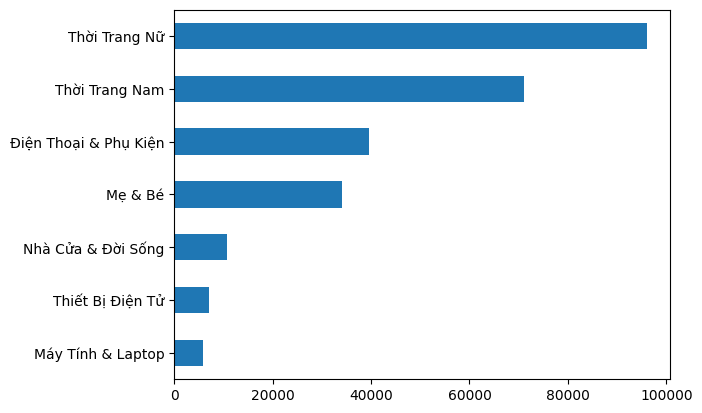

In [13]:
df_notlike.category.value_counts().sort_values().plot(kind = 'barh')

### 
In this class, most highlighted categories:
- Thời trang nam
- Thời trang nữ
- Đt & Phụ kiên
- Mẹ và bé
### however Thoi Trang (Fashion categories) accounted for the largest.

### NEUTRAL

In [14]:
df_neutral= df1[df1['rating'] == 3 ]

In [15]:
df_neutral['category'].value_counts()

Thời Trang Nữ            69337
Thời Trang Nam           67419
Mẹ & Bé                  26594
Điện Thoại & Phụ Kiện    22240
Nhà Cửa & Đời Sống        4775
Thiết Bị Điện Tử          4074
Máy Tính & Laptop         3528
Name: category, dtype: int64

<AxesSubplot: >

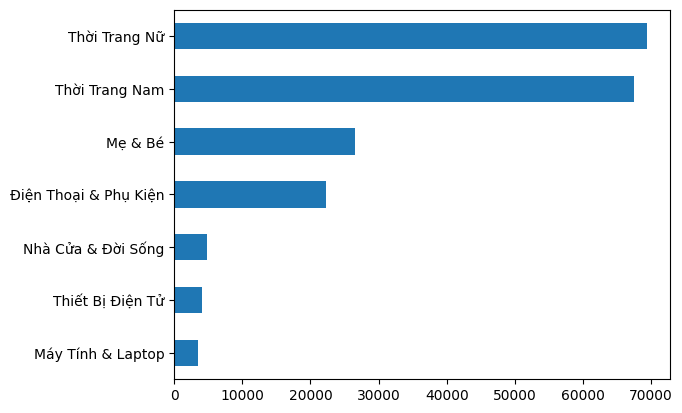

In [16]:
df_neutral.category.value_counts().sort_values().plot(kind = 'barh')

####
- Its quite similar to 'not like' class

### LIKE

In [17]:
df_like = df1[df1['rating'] > 3 ]

In [18]:
df_like['category'].value_counts()

Thời Trang Nam           903315
Thời Trang Nữ            418770
Mẹ & Bé                   44278
Điện Thoại & Phụ Kiện     35673
Thiết Bị Điện Tử           6075
Máy Tính & Laptop          5470
Nhà Cửa & Đời Sống         2916
Name: category, dtype: int64

<AxesSubplot: >

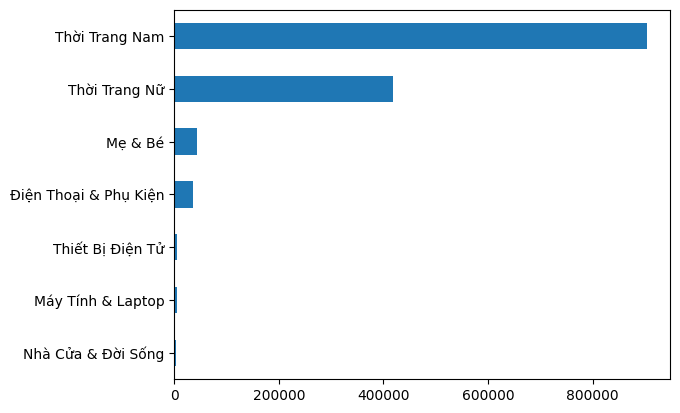

In [19]:
df_like.category.value_counts().sort_values().plot(kind = 'barh')

###
- in this class, the dominance can be differentiable obviously

### Isnull 
- can we eliminate NaN  
- Or Comments with NaN, what were they rated?

In [20]:
df2 = df1[["rating","comment"]].copy()

In [21]:
df2.isna().sum()

rating          0
comment    955139
dtype: int64

In [22]:
df2.isnull().sum()

rating          0
comment    955139
dtype: int64

In [23]:
df_isnull = df2[df2['comment'].isnull()]

In [24]:
df_isnull.head()

,rating,comment
2,3,NaN
3,3,NaN
8,1,NaN
12,1,NaN
14,3,NaN


In [25]:
df_count = df_isnull['rating'].value_counts()
df_result = pd.DataFrame(df_count)
df_result = df_result.reset_index()
df_result.columns = ['rating','value_counts']
print(df_result)

   rating  value_counts
0       5        647505
1       4        143949
2       3         85940
3       1         43620
4       2         34125


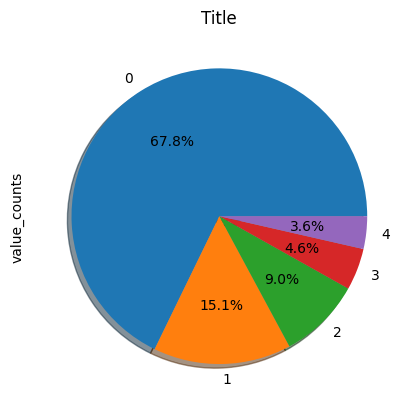

In [26]:
plot = df_result.plot.pie(y='value_counts', title="Title", legend=False, \
                   autopct='%1.1f%%', \
                   shadow=True, startangle=0)

### 
- over 90% NaN values belongs to rating 3 -5, and over 80% belongs to 4-5
- they tells us 'Blank' comments mean they was satisfied with the service, or at least neutral rating.
- look back to the dataset, rating 'postivie' accounted for the vast majority of datatset, while positive class also recorded as highest percentage in NaN value. Therefore Nan values can be excluded from the dataset:
 + avoid imbalance
 + optimize computing for local computer

In [27]:
df3 = df1[~df1['comment'].isnull()]

In [28]:
# Check duplicates
df3.duplicated().sum()

6963

In [29]:
# Drop duplicates
df3.drop_duplicates(inplace=True)

In [30]:
df3.shape

(934543, 6)

### 
- Trong bài toán này, bộ dữ liệu chỉ cần giữ lại feature rating và comment

In [31]:
df4 = df3[['rating','comment']]

In [32]:
conditions = [
    (df4['rating'] < 3),
    (df4['rating'] == 3),
    (df4['rating'] > 3)
]

values = ['not like', 'neutral', 'like']

df4['class'] = np.select(conditions, values)
df4 = df4[['comment','class']]

In [33]:
df4.reset_index(drop=True, inplace=True)

In [34]:
df4.head()

,comment,class
0,Miếng dán hơi dầy ko thẩm mỹ. Qan trong là ko ...,neutral
1,"Mua nhiều miếng dán ở shop rồi, nhưng thật sự ...",neutral
2,"Giao sai sp, đặt 1 cường lực trắng cho 8+ nhưn...",not like
3,"Đã nhận đc hàng, cảm quan ban đầu thì khá ok, ...",not like
4,Chất lượng cái cường lực chống nhìn trộm không...,not like


In [35]:
df4['class'].value_counts()

like        636052
not like    186399
neutral     112092
Name: class, dtype: int64

### 
- for some reasons, 50% of dataset will be utilized in this project:
 + litmited resources for computing, 
 + the dominance of positive class in the dataset generally, also NaN

In [36]:
df_sub = (df4[df4['class']== 'like']).sample(frac=0.5)

In [37]:
df_sub.shape

(318026, 2)

In [38]:
df = df4.drop(df_sub.index)

In [39]:
df['class'].value_counts()

like        318026
not like    186399
neutral     112092
Name: class, dtype: int64

In [40]:
from xulyvni import *

In [41]:
#x = xuly_vni(subset_df)

In [42]:
#x.head()

### Clean Text

### 
- Multiprocessing will be used by import DASK 

In [43]:
# Create a cluster
cluster = LocalCluster()
client = Client(cluster)
dask.config.set(scheduler='multiprocessing')

2023-03-23 11:01:19,172 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/dask-worker-space/worker-v0r2orax', purging
2023-03-23 11:01:19,172 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/dask-worker-space/worker-1xj09nyb', purging
2023-03-23 11:01:19,173 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/dask-worker-space/worker-1ia_264x', purging
2023-03-23 11:01:19,174 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6v/nymwmjk912d8glyc17sfhddr0000gn/T/dask-worker-space/worker-9retw4xd', purging


In [44]:
from xulyvni import xuly_vni

In [45]:
# Create a dask dataframe from the pandas dataframe
ddf = dd.from_pandas(df, npartitions=16)
ddf = ddf.map_partitions(xuly_vni)

In [46]:
# Convert the dask dataframe to pandas dataframe
print('Converting dask dataframe to pandas dataframe...')
with ProgressBar():
    df = ddf.compute(num_workers=7)

# Free up memory
del ddf

Converting dask dataframe to pandas dataframe...
[########################################] | 100% Completed | 24m 27s


In [47]:
# Check the first 5 rows
df.head()

,comment,class,processed_text
0,Miếng dán hơi dầy ko thẩm mỹ. Qan trong là ko ...,neutral,miếng dán hơi dầy không_thẩm
1,"Mua nhiều miếng dán ở shop rồi, nhưng thật sự ...",neutral,miếng dán tồi bóc bụi giải_quyết thỏa_đáng điệ...
2,"Giao sai sp, đặt 1 cường lực trắng cho 8+ nhưn...",not like,cường_lực trắng màu đen
3,"Đã nhận đc hàng, cảm quan ban đầu thì khá ok, ...",not like,hàng cảm_quan đầu mặt xước dã dán chiều tối xư...
4,Chất lượng cái cường lực chống nhìn trộm không...,not like,chất_lượng cường_lực chống trộm không_như quản...


In [48]:
df.reset_index(drop=True, inplace=True)

In [49]:
df.head()

,comment,class,processed_text
0,Miếng dán hơi dầy ko thẩm mỹ. Qan trong là ko ...,neutral,miếng dán hơi dầy không_thẩm
1,"Mua nhiều miếng dán ở shop rồi, nhưng thật sự ...",neutral,miếng dán tồi bóc bụi giải_quyết thỏa_đáng điệ...
2,"Giao sai sp, đặt 1 cường lực trắng cho 8+ nhưn...",not like,cường_lực trắng màu đen
3,"Đã nhận đc hàng, cảm quan ban đầu thì khá ok, ...",not like,hàng cảm_quan đầu mặt xước dã dán chiều tối xư...
4,Chất lượng cái cường lực chống nhìn trộm không...,not like,chất_lượng cường_lực chống trộm không_như quản...


In [50]:
df_final = df[['processed_text','class']]

In [51]:
df_final.head()

,processed_text,class
0,miếng dán hơi dầy không_thẩm,neutral
1,miếng dán tồi bóc bụi giải_quyết thỏa_đáng điệ...,neutral
2,cường_lực trắng màu đen,not like
3,hàng cảm_quan đầu mặt xước dã dán chiều tối xư...,not like
4,chất_lượng cường_lực chống trộm không_như quản...,not like


In [52]:
df_final['processed_text'].loc[1]

'miếng dán tồi bóc bụi giải_quyết thỏa_đáng điện_thoại'

In [53]:
df_final.to_csv('shopee_final.csv')

### Visualize 

###
- Trực quan hoá bằng Wordcloud theo class

### Not Like (unsatisfied)

In [54]:
df_final_notlike = df_final[df_final['class'] == 'not like' ]

In [55]:
# not Like
wc_notlike = WordCloud(
    background_color='black',
    max_words=500
)
# generate the word cloud
wc_notlike.generate(str(df_final_notlike['processed_text'].values))

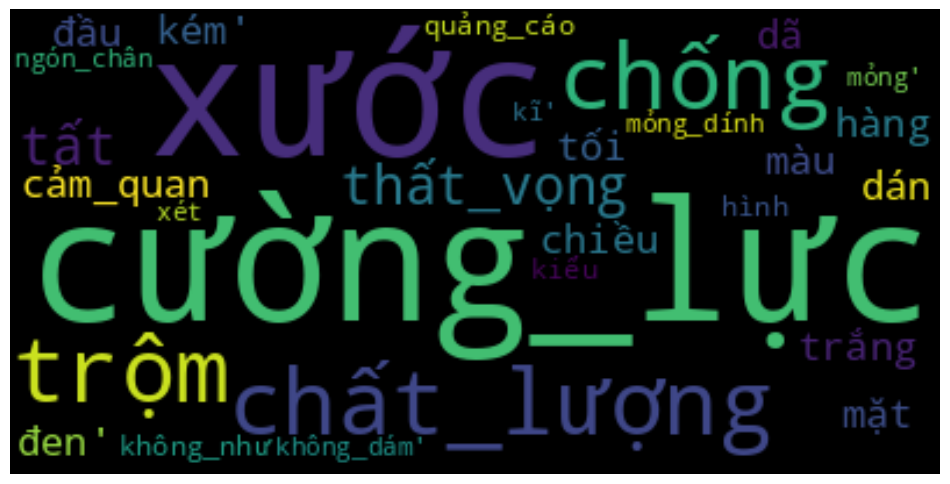

In [56]:
# display the word clouds
plt.figure(figsize=(12, 12))
plt.imshow(wc_notlike, interpolation='bilinear')
plt.axis('off')
plt.show()

### Comments:
- Most comments related to negative class: chất lượng (quality), kiểu dáng (shape), quảng cáo (advertising).

### Neutral (trung tính)

In [57]:
df_final_neutral = df_final[df_final['class'] == 'neutral' ]
# Neutral
wc_neutral = WordCloud(
    background_color='black',
    max_words=500
)
# generate the word cloud
wc_neutral.generate(str(df_final_neutral['processed_text'].values))

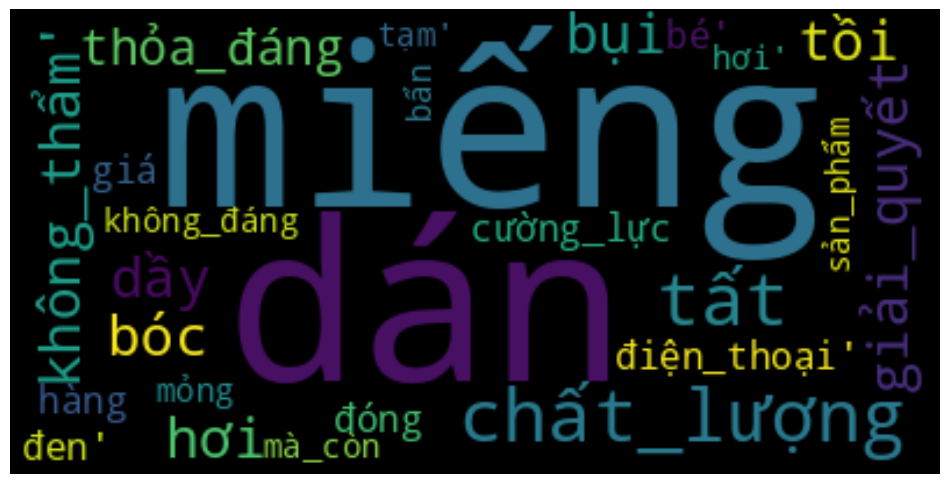

In [58]:
# display the word clouds
plt.figure(figsize=(12, 12))
plt.imshow(wc_neutral, interpolation='bilinear')
plt.axis('off')
plt.show()

### Comments:
- cường lực (temper), mỏng (thin), chất lượng (quality)

### Like (Hài lòng)

In [59]:
df_final_like = df_final[df_final['class'] == 'like' ]
# Neutral
wc_like = WordCloud(
    background_color='black',
    max_words=500
)
# generate the word cloud
wc_like.generate(str(df_final_like['processed_text'].values))

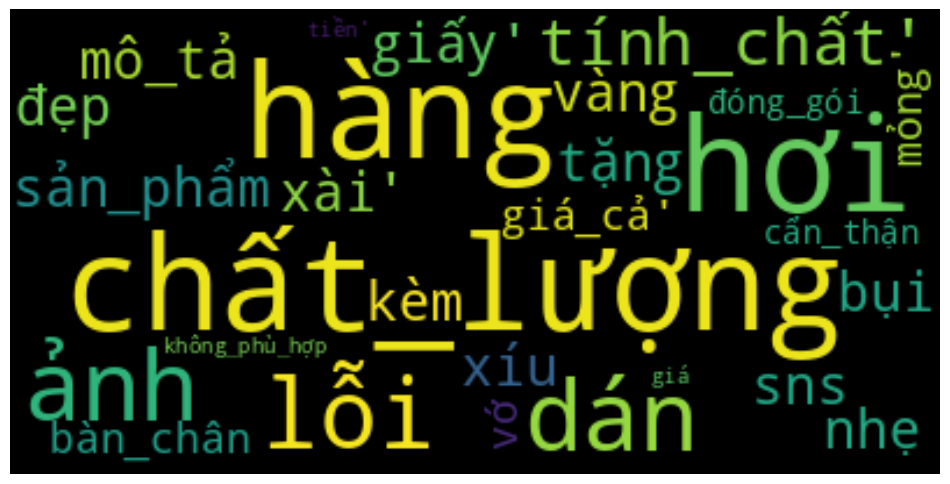

In [60]:
# display the word clouds
plt.figure(figsize=(12, 12))
plt.imshow(wc_like, interpolation='bilinear')
plt.axis('off')
plt.show()

### comments:
- chất lượng (Quality), sản phẩm (Products), giá cả (Price), cẩn thận (Carefulness)...